# An introduction to the SpecOneD class
In this notebook we will demonstrate the functionality of the SpecOneD class included in the speconed modules as part of *Sculptor*. SpecOneD objects are designed to hold the spectral information of an astronomical source along with ancillary information, such as the data header generated by the observatory or the reduction software or the physical units of the dispersion and flux density axis.

## Introducing the SpecOneD object
We begin by introducing the SpecOneD object and its attributes. As a first step we import the SpecOneD module from sculptor and generate an emptye SpecOneD object. 

In [1]:
# Import the speconed module from sculptor
from sculptor import speconed as sod

# Instantiate an empty SpecOneD object
spec = sod.SpecOneD()

We have now instantiated an empty SpecOneD object called *spec*. Let's take a quick look at the class attributes by iterating over them.

In [2]:
for key in vars(spec).keys():
    print(f'{key}')

fluxden
fluxden_err
dispersion
fluxden_ivar
mask
dispersion_unit
fluxden_unit
header
fits_header
obj_model
telluric


Every SpecOneD object will be instantiated with a range of numpy.ndarrays holding information on the dispersion axis (dispersion), the flux density (fluxden), the flux density error (fluxden_err), a mask (mask). All of these arrays have to have the same length. 

In addition, the two attributes "dispersion_unit" and "fluxden_unit" contain the information on the physical units of the dispersion axis as well as the flux density (and flux density error). These attributes are populated with astropy.units.Quantity (astropy.units.Unit, astropy.units.CompositeUnit, astropy.units.IrreducibleUnit) enabling to use the astropy.units module for unit conversion. This is also an important aspect for the analysis of the spectral models later on.

The "header" attribute is a pandas.DataFrame with additional information of the spectrum. If the header was populated through a fits file the original fits header is available at the "fits_header" attribute. Note that when initializing a SpecOneD object you should pass your fits header under the *header* keyword.

Spectra reduced by *PypeIt* and read in from the *PypeIt* fits format might carry additional information about the object_model and the telluric model from the telluric correction, which will be saved in the "obj_model" and "telluric" attributes. 

## Manual initialization of a SpecOneD object
While the SpecOneD class offers functionality to import spectra from iraf or PypeIt standard data reductions and also supports the SDSS format, it is important to know how to initialize spectra manually for custom use. For this example we use the SDSS spectrum of the quasar J030341.04-002321.8 available in the sculptor data folder.  

In [3]:
# Let's begin by importing astropy fits and units functionality
from astropy.io import fits
import astropy.units as units

# Define the name of the example spectrum
spec_filename = '../../sculptor/data/example_spectra/J030341.04-002321.8_0.fits'

# Read in the example spectrum with astropy
hdu = fits.open(spec_filename)

# Extract the dispersion axis, the flux density and the error from the fits file
dispersion = hdu[1].data['loglam']
flux_density = hdu[1].data['flux']
flux_density_ivar = hdu[1].data['ivar']

# Extract the fits header of the spectrum 
header = hdu[0].header

# Before we initialize the SpecOneD object we need to convert the dispersion axis to a linear scale
dispersion = 10**dispersion

# The header provides information on the units of the spectrum (Let's print it out below!)
print('Wavelength unit: {}'.format(header['WAT1_001']))
print('Flux density unit: {}'.format(header['BUNIT']))

dispersion_unit = 1.*units.AA
fluxden_unit = 1e-17 * units.erg/units.s/units.cm**2/units.AA

# Now we can initialize a SpecOneD object manually
spec = sod.SpecOneD(dispersion=dispersion, fluxden=flux_density, fluxden_ivar=flux_density_ivar,
                   fluxden_unit=fluxden_unit, dispersion_unit=dispersion_unit, header=header)

Wavelength unit: wtype=linear label=Wavelength units=Angstroms
Flux density unit: 1E-17 erg/cm^2/s/Ang


**We have done it! We have manually initialized a SpecOneD object**

Let us now take a closer look if everything worked. We begin by checking the types and shapes of the main SpecOneD attributes: *flux density*, *dispersion*, *mask*, *flux density error*, the units and the header

In [4]:
print('Flux density -  type {}, size {} \n'.format(type(spec.fluxden), spec.fluxden.shape))
print('Dispersion axis -  type {}, size {} \n'.format(type(spec.dispersion), spec.dispersion.shape))
print('Flux density error -  type {}, size {} \n'.format(type(spec.fluxden_err), spec.fluxden_err.shape))
print('Mask -  type {}, size {} \n'.format(type(spec.mask), spec.mask.shape))

print('Dispersion unit -  value {} and type {} \n'.format(spec.dispersion_unit, type(spec.dispersion_unit)))
print('Flux density unit - value {} and type {} \n'.format(spec.fluxden_unit, type(spec.fluxden_unit)))

print('Header DataFrame \n', spec.header)

Flux density -  type <class 'numpy.ndarray'>, size (3614,) 

Dispersion axis -  type <class 'numpy.ndarray'>, size (3614,) 

Flux density error -  type <class 'numpy.ndarray'>, size (3614,) 

Mask -  type <class 'numpy.ndarray'>, size (3614,) 

Dispersion unit -  value 1.0 Angstrom and type <class 'astropy.units.quantity.Quantity'> 

Flux density unit - value 1e-17 erg / (Angstrom cm2 s) and type <class 'astropy.units.quantity.Quantity'> 

Header DataFrame 
                                  value
SIMPLE                            True
BITPIX                               8
NAXIS                                0
EXTEND                            True
TAI                      4477028053.74
...                                ...
EXPID02  b1-00006799-00006802-00006803
EXPID03  b1-00006800-00006802-00006803
EXPID04  r1-00006798-00006802-00006803
EXPID05  r1-00006799-00006802-00006803
EXPID06  r1-00006800-00006802-00006803

[138 rows x 1 columns]


Everything seems to look reasonable here. However, a visual inspection of the spectrum will be necessary to convince us that it was read in correctly. For this purpose the SpecOneD class offers a simple plot functionality:

## Using .plot() for quick visualization of the spectrum

The spectrum can be plotted with the built-in plot functionality, which uses matplotlib. Note that the units in the axis labels will be automatically populated by the units from the SpecOneD object (spec.dispersion_unit, spec.fluxden_unit).

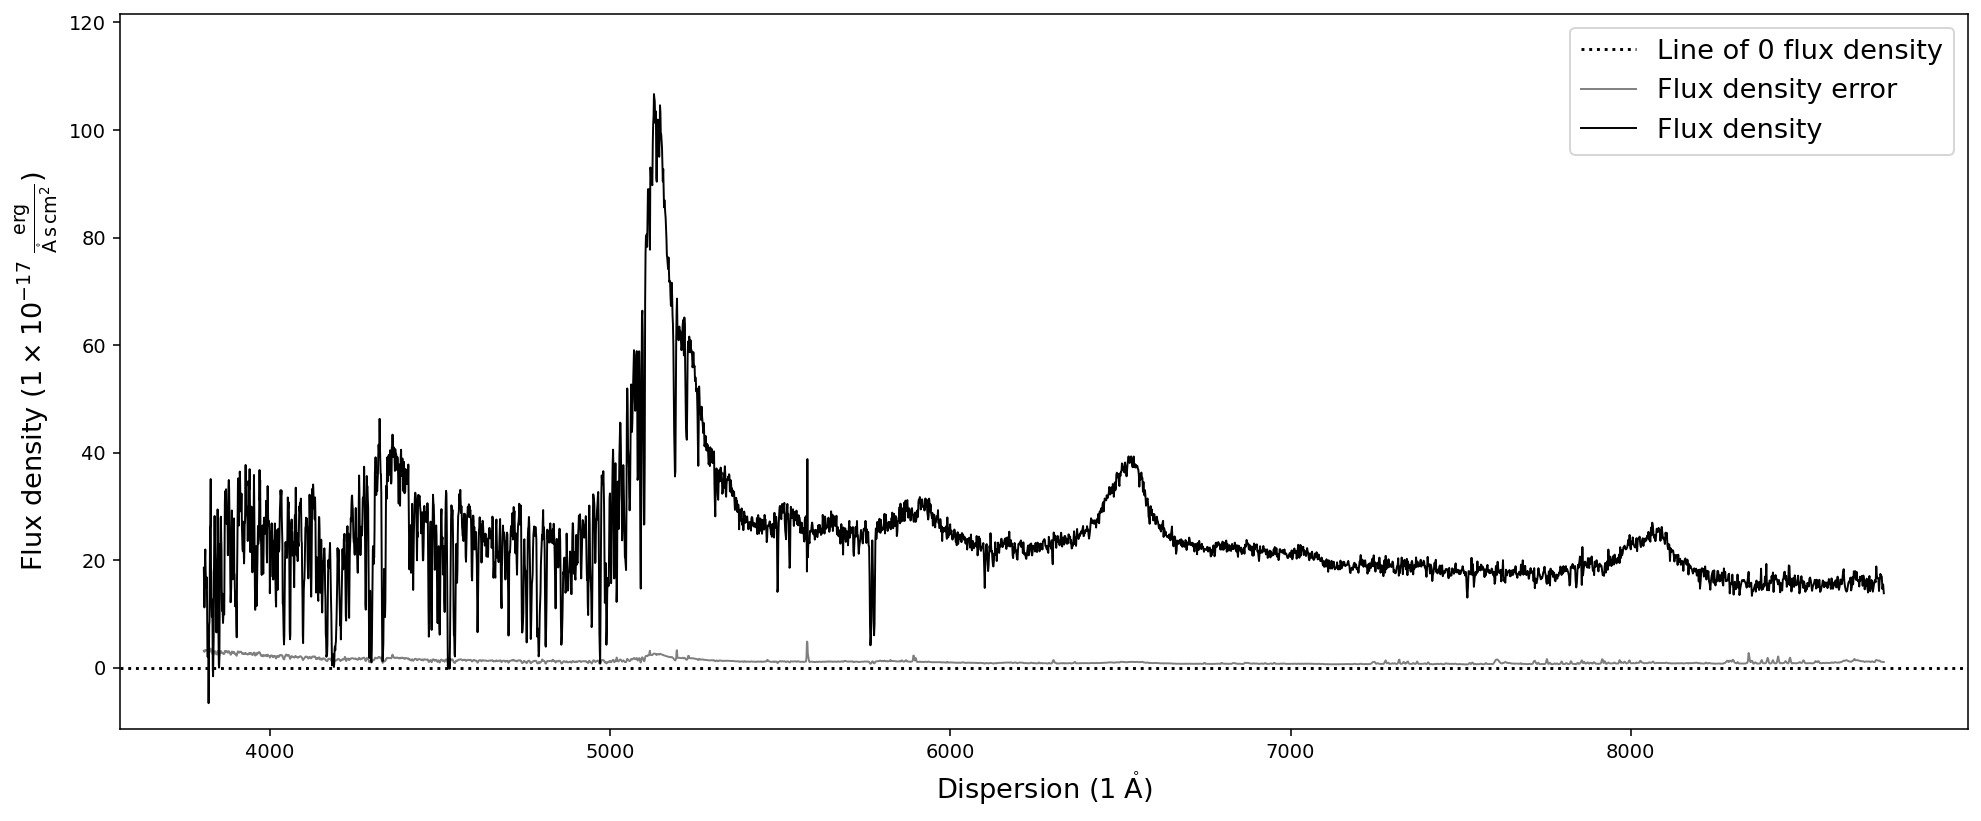

In [5]:
spec.plot()

We expect the source to be a quasar at redshift z=3.227. Therefore we expect the Lyman-alpha emission line around 5140A. A look at the plot convinces us that the spectrum was read in correctly, including the axis units.

## Saving and reading in SpecOneD objects
Sculptor and the Sculptor GUI require a SpecOneD object as input. The GUI allow to import spectra from a few common fits formats or from a saved SpecOneD object.

SpecOneD allows to save spectra to the *hdf* format, which is the native way to save spectra within the SpecOneD class. The spectral data, meta data and the header will be saved in a file, which can be easily imported to the Sculptor GUI. 

In [6]:
# Saving the SpecOneD spectrum in its native format
spec.save_to_hdf('temp_spectrum.hdf5')

/opt/anaconda3/envs/sculptor-env/lib/python3.9/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['value'], dtype='object')]

  pytables.to_hdf(


In a similar fashion we can read in the spectrum again:

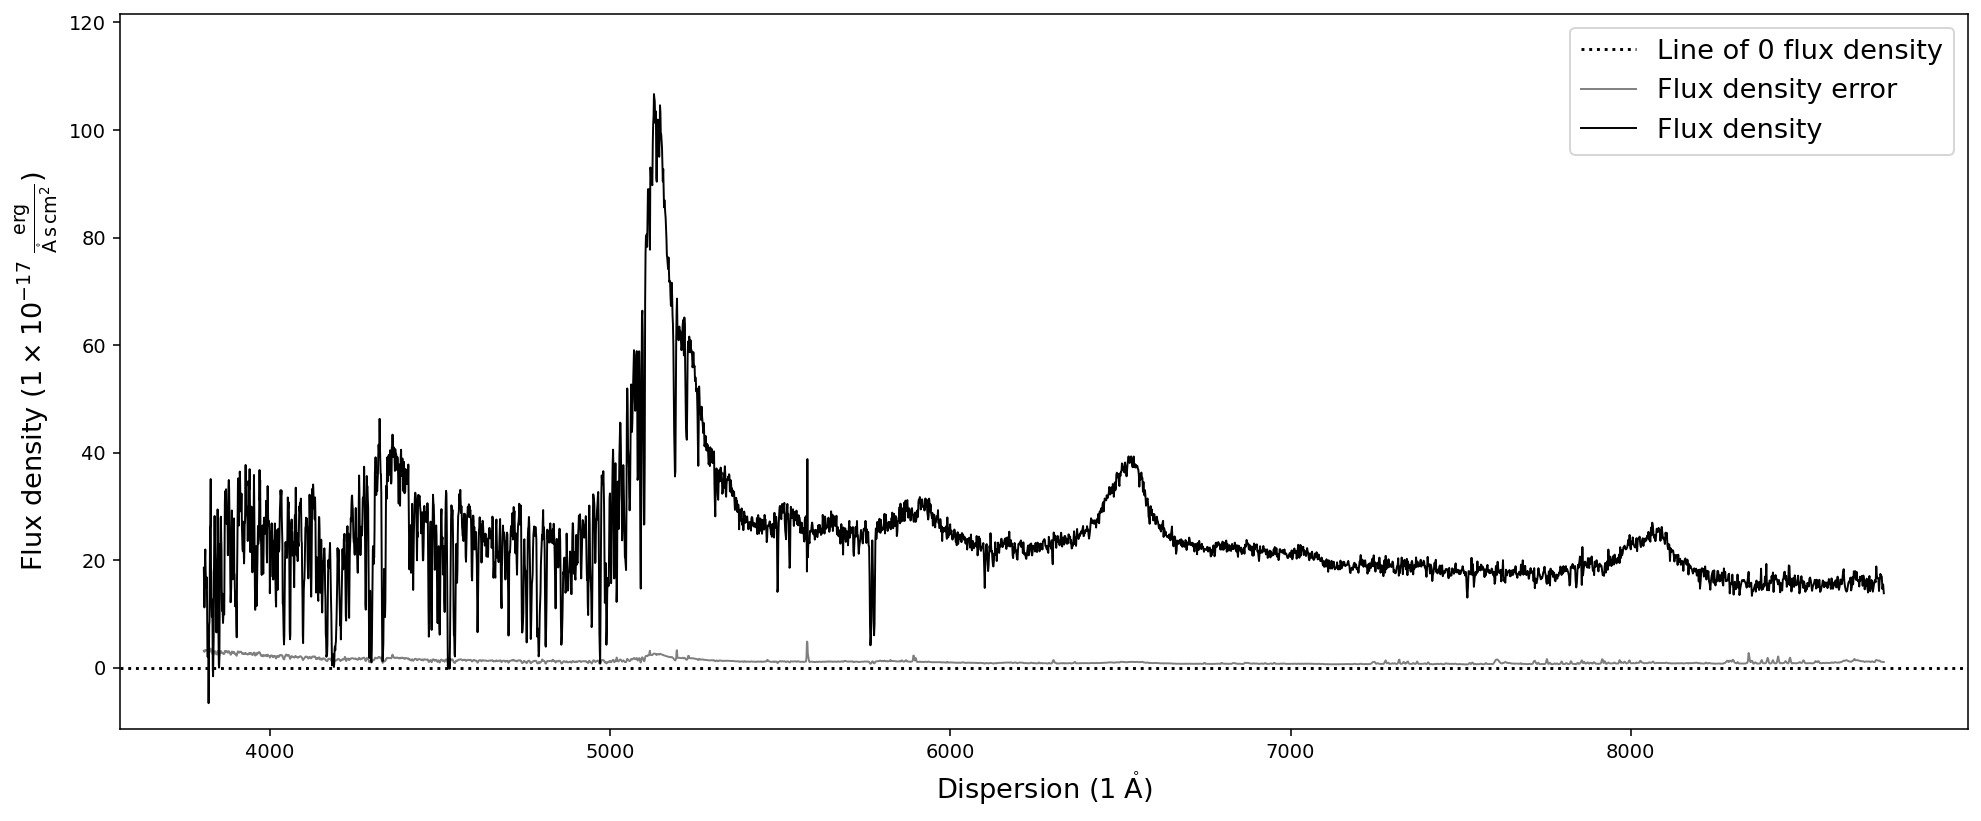

Flux density unit according to header is 1E-17 erg/cm^2/s/Ang
The fits header attribute is: None


In [7]:
# Before we read in a SpecOneD object, we need to initialize an empty object
new_spec = sod.SpecOneD()
# Then we use the read_from_hdf function and the filename
new_spec.read_from_hdf('temp_spectrum.hdf5')

# As a test we plot the spectrum
new_spec.plot()
# and test if the header was saved and read in correctly
print('Flux density unit according to header is {}'.format(new_spec.header.loc['BUNIT','value']))

# However, the fits header attribute is not populated
print('The fits header attribute is: {}'.format(new_spec.fits_header))

# To keep the notebook directoy clean we delete the temporary spectrum file 
! rm temp_spectrum.hdf5

Great! The spectrum was saved and read in correctly.

**Note: Because we did not initialize the new spectrum from a fits file the *fits_header* attribute is *None*.**

## Reading in spectra from other formats

In the current version of Sculptor the SpecOneD module has three implemented methods to read in spectra from
* an IRAF 1D fits file (in many cases the flux density and dispersion units need to be set manually)
* an PypeIT 1D fits file
* an SDSS fits file

These read function automizes the steps of the manual initialization above. We now go through quick examples:

We begin by readin in the SDSS quasar spectrum from before in only two lines:

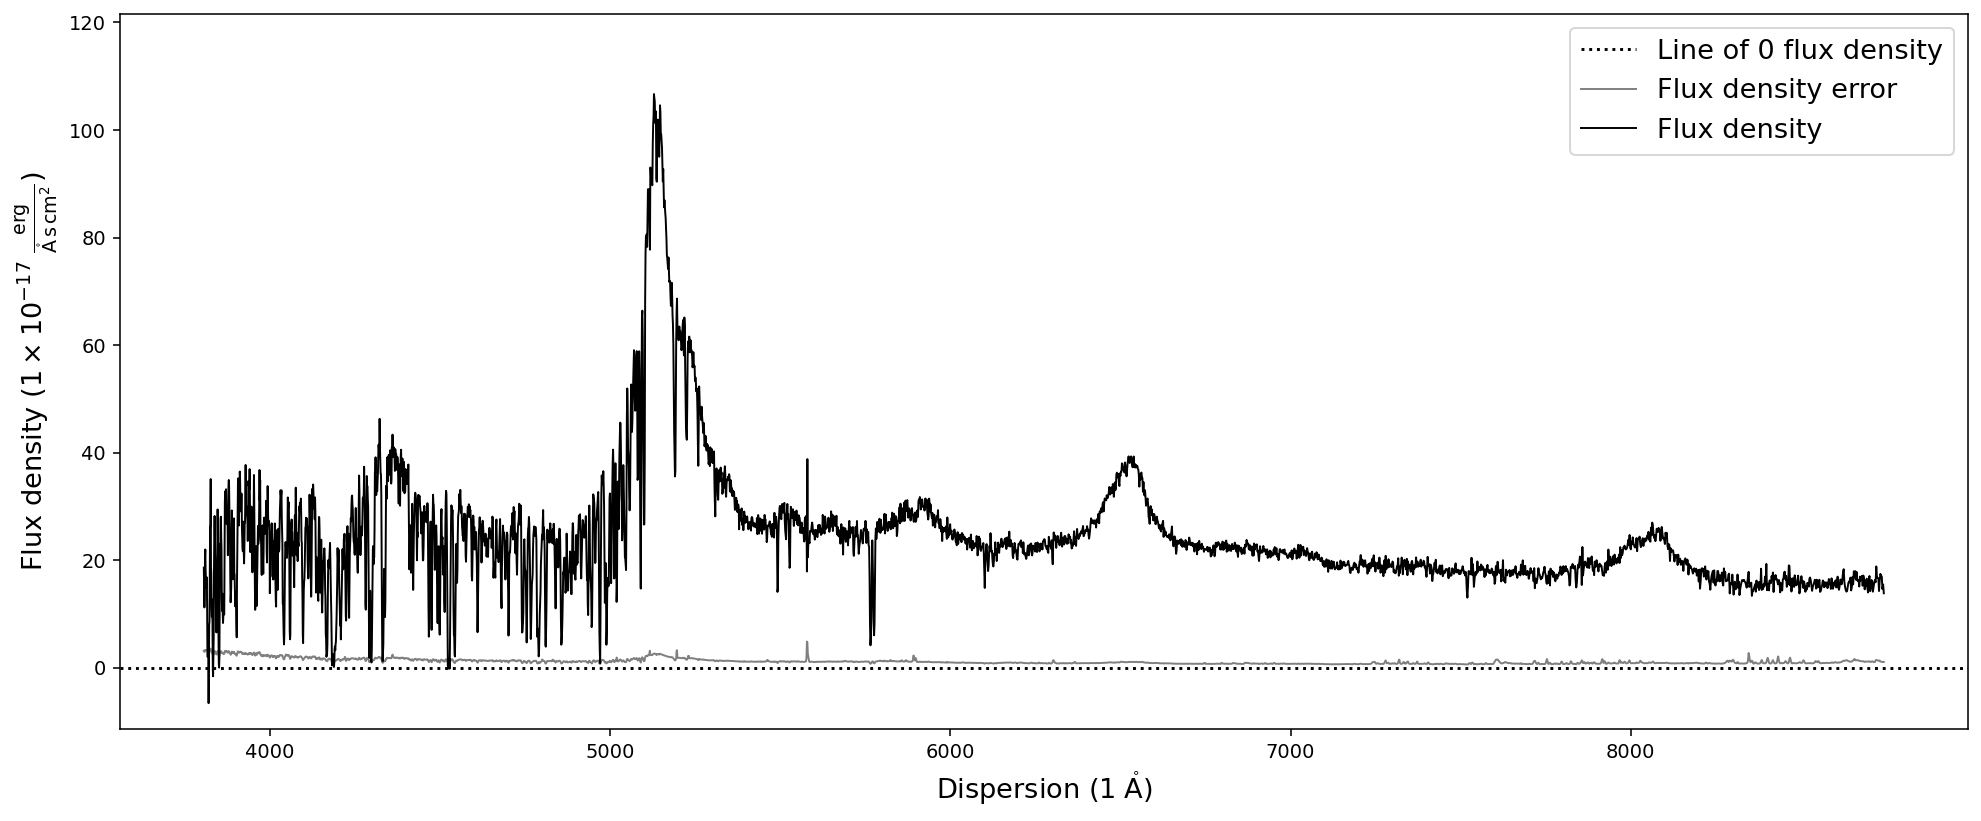

In [8]:
# Initializing an empty SpecOneD object
sdss_spec = sod.SpecOneD()
# Read in the spectrum using the SDSS read function
sdss_spec.read_sdss_fits('../../sculptor/data/example_spectra/J030341.04-002321.8_0.fits')
# Plot the spectrum 
sdss_spec.plot()

The Sculptor data directory also includes example (quasar) spectra in IRAF and PypeIT fits format. Reading them in as a SpecOneD object is just as simple as in the case of the SDSS spectrum.

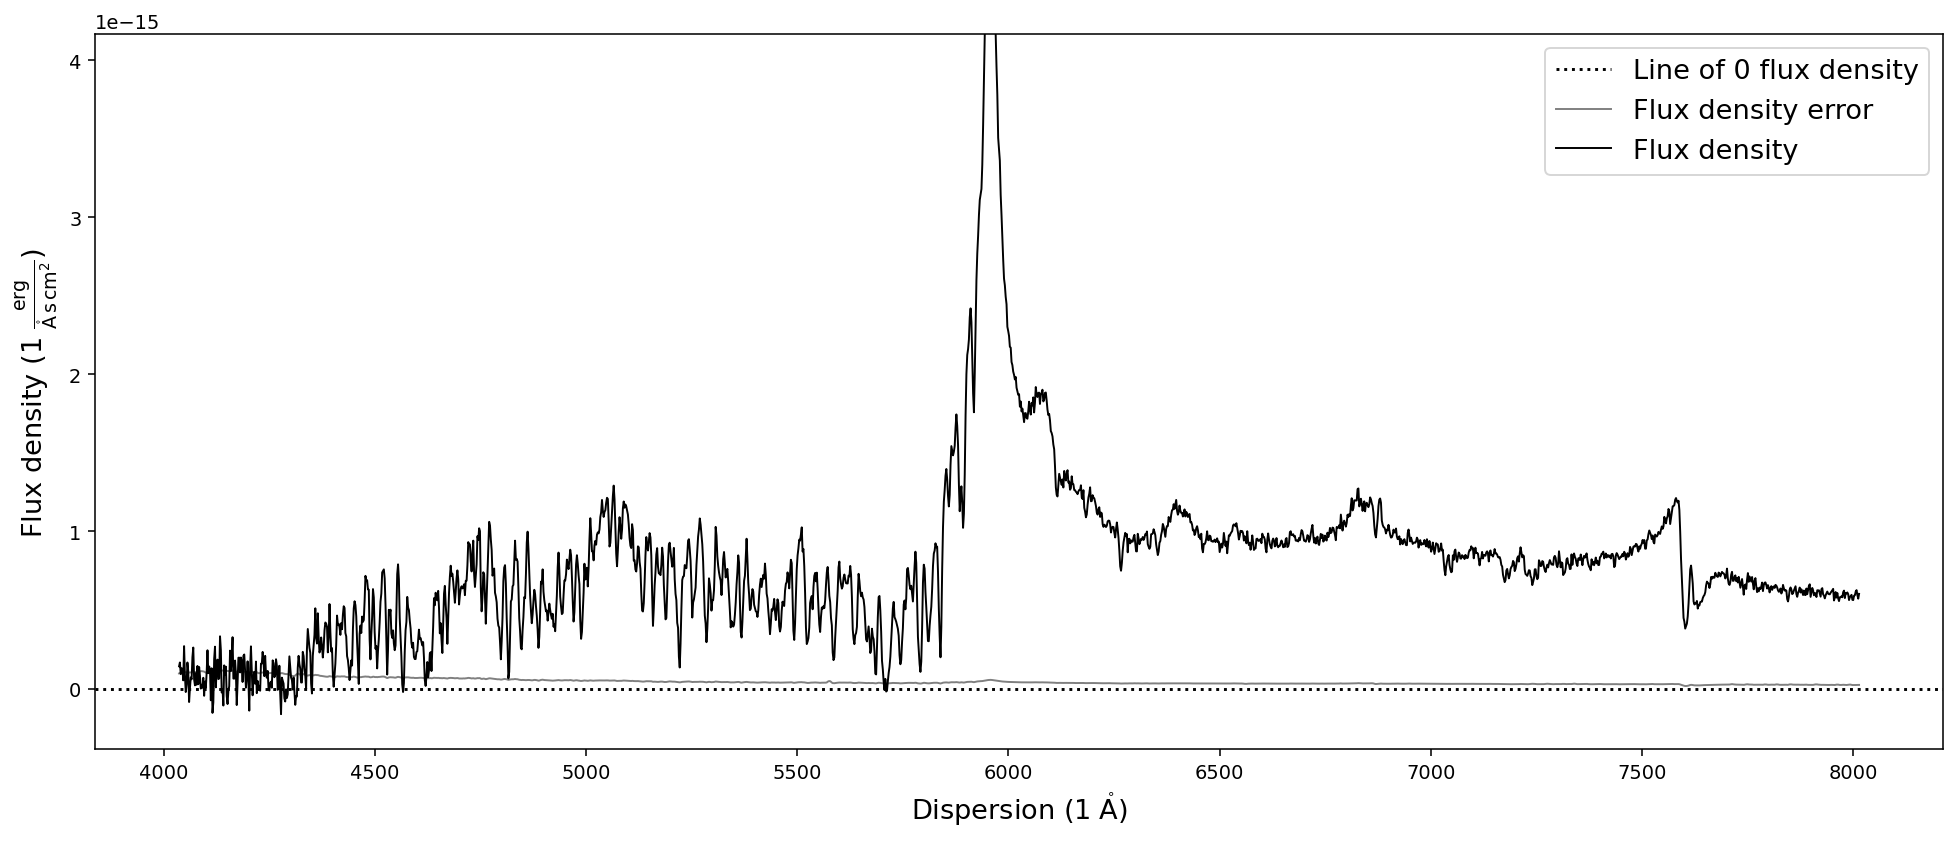

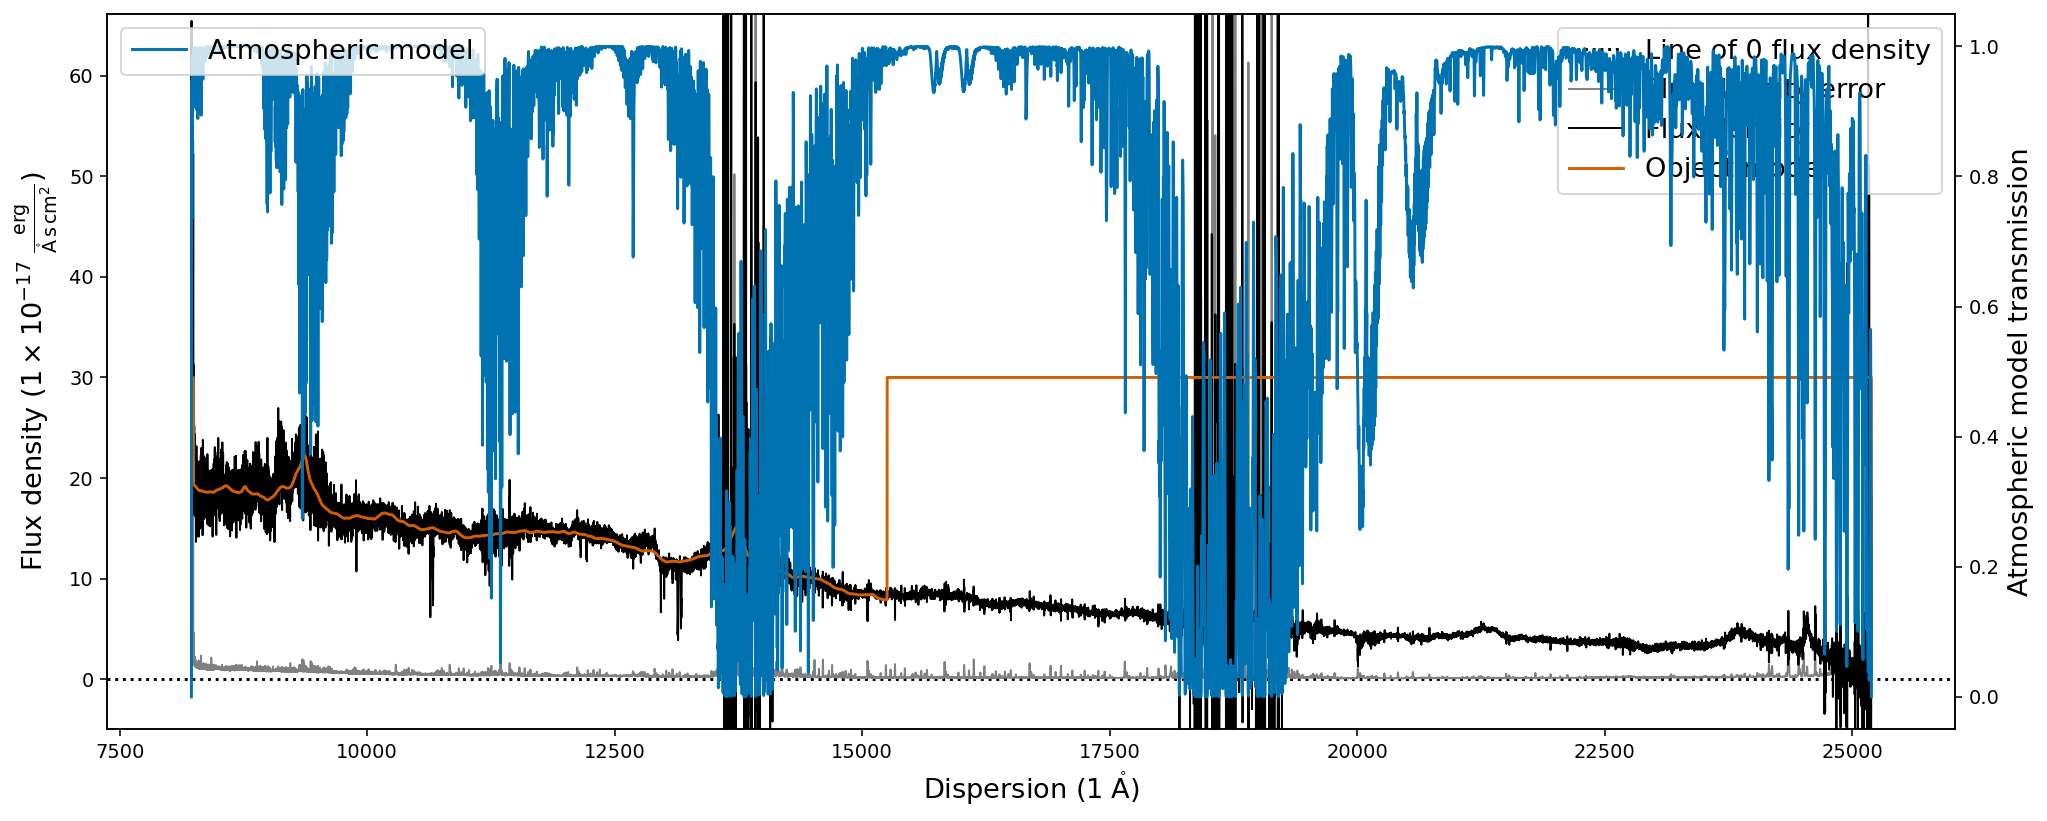

In [9]:
# Initializing an empty SpecOneD object 
iraf_spec = sod.SpecOneD()
# Read in the spectrum using the IRAF read function
iraf_spec.read_from_fits('../../sculptor/data/example_spectra/J2125-1719_OPT_A.fits')
# Plot the spectrum 
iraf_spec.plot()

# Initializing an empty SpecOneD object
pypeit_spec = sod.SpecOneD()
# Read in the spectrum using the PypeIt read function
pypeit_spec.read_pypeit_fits('../../sculptor/data/example_spectra/J2125-1719_NIR.fits')
# Plot the spectrum 
pypeit_spec.plot()

The first plot shows the optical spectrum of the ultra-luminous quasar J2125-1719, whereas the second shows the near-infrared spectrum. 

The second plot however does show additional information, the object model (orange) and the atmospheric transmission (blue) from the PypeIt telluric correction routines. It also shows that the default *.plot()* capabilities of the SpecOneD class are not appropriate for generating publication grade figures as the legends in the second plot are not well placed.

## Unit conversions

With the flux density and dispersion units included as astropy unit classes within the SpecOneD object, we have all the great unit conversion functionality of astropy.units at our disposal. We want to briefly demonstrate how this works. Let us begin again with our default SDSS quasar spectrum *sdss_spec*. The default units were 

In [10]:
print(sdss_spec.fluxden_unit)
print(sdss_spec.dispersion_unit)

1e-17 erg / (Angstrom cm2 s)
1.0 Angstrom


The function *convert_spectral_units* allows us to convert the spectral units by specifying the new dispersion and new flux density unit. 

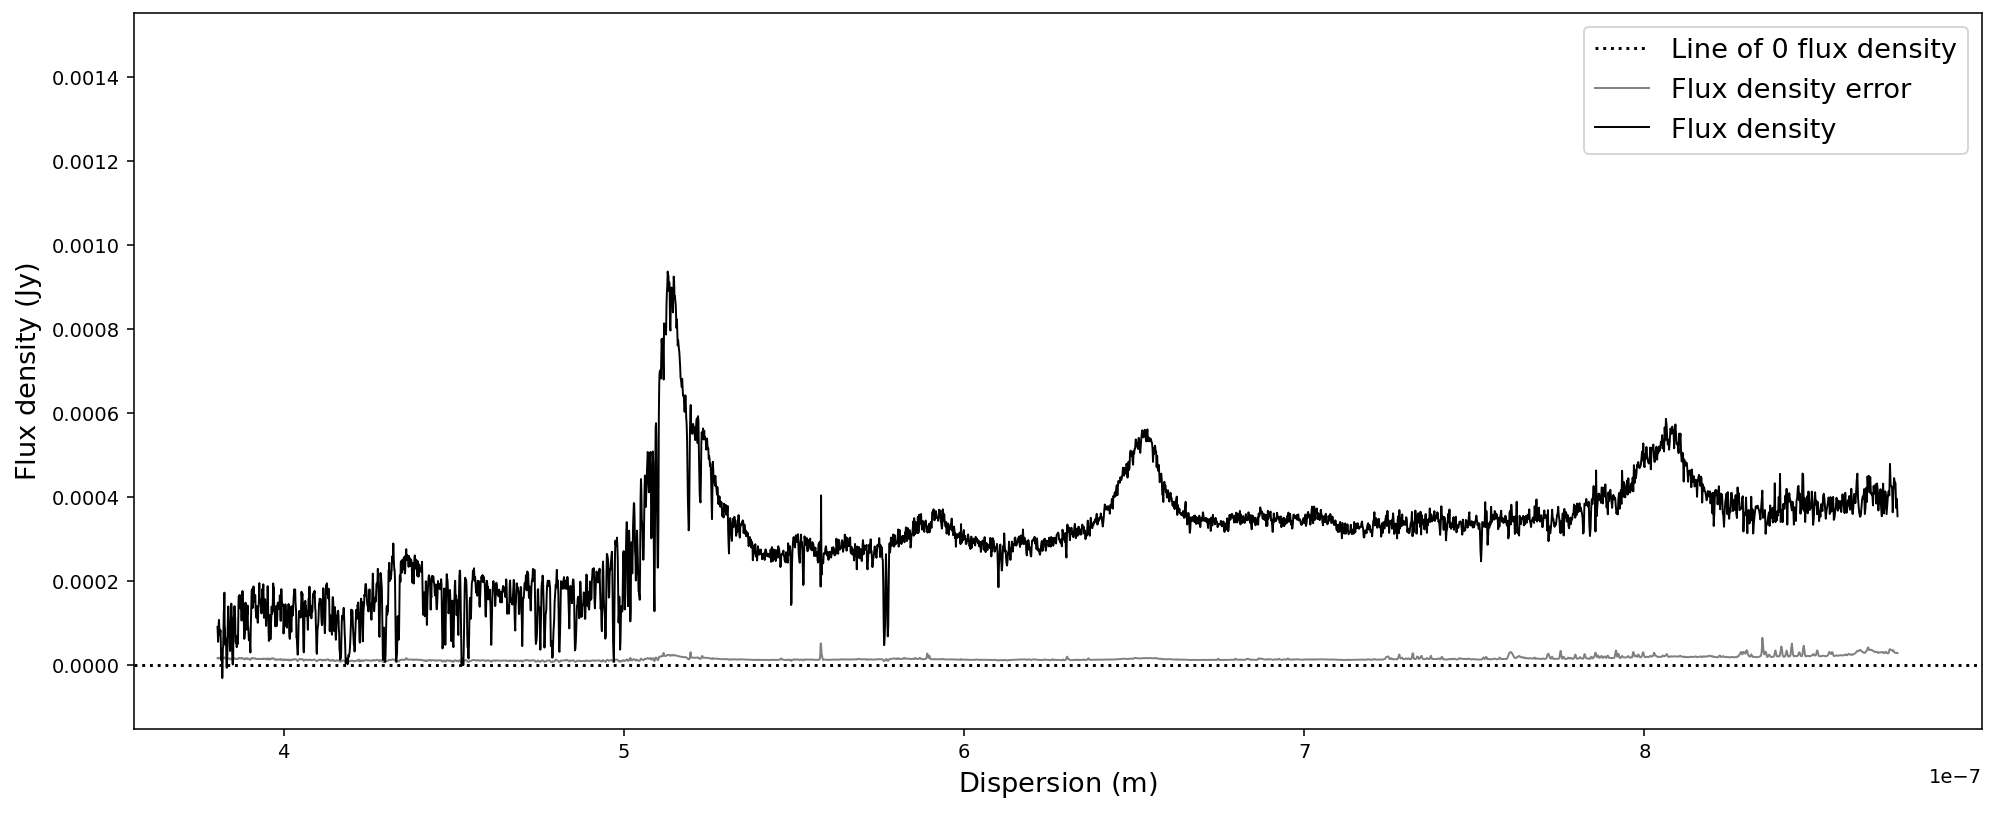

In [11]:
# Convert the dispersion to meters and the flux density to Jansky
sdss_spec.convert_spectral_units(1*units.m,1*units.Jy)
# Display the spectrum 
sdss_spec.plot()

As long as the new units are reasonable for a flux density and a dispersion axis, you will be able to convert the spectrum. Internally the conversion uses *spectral* and *spectral_density* equivalencies, which will lead to an error if one would choose units that do not obey these equivalencies. Please consult the [astropy documentation](https://docs.astropy.org/en/stable/units/equivalencies.html) for details.

For our case, the SpecOneD class comes with default conversion functions for common spectral units:

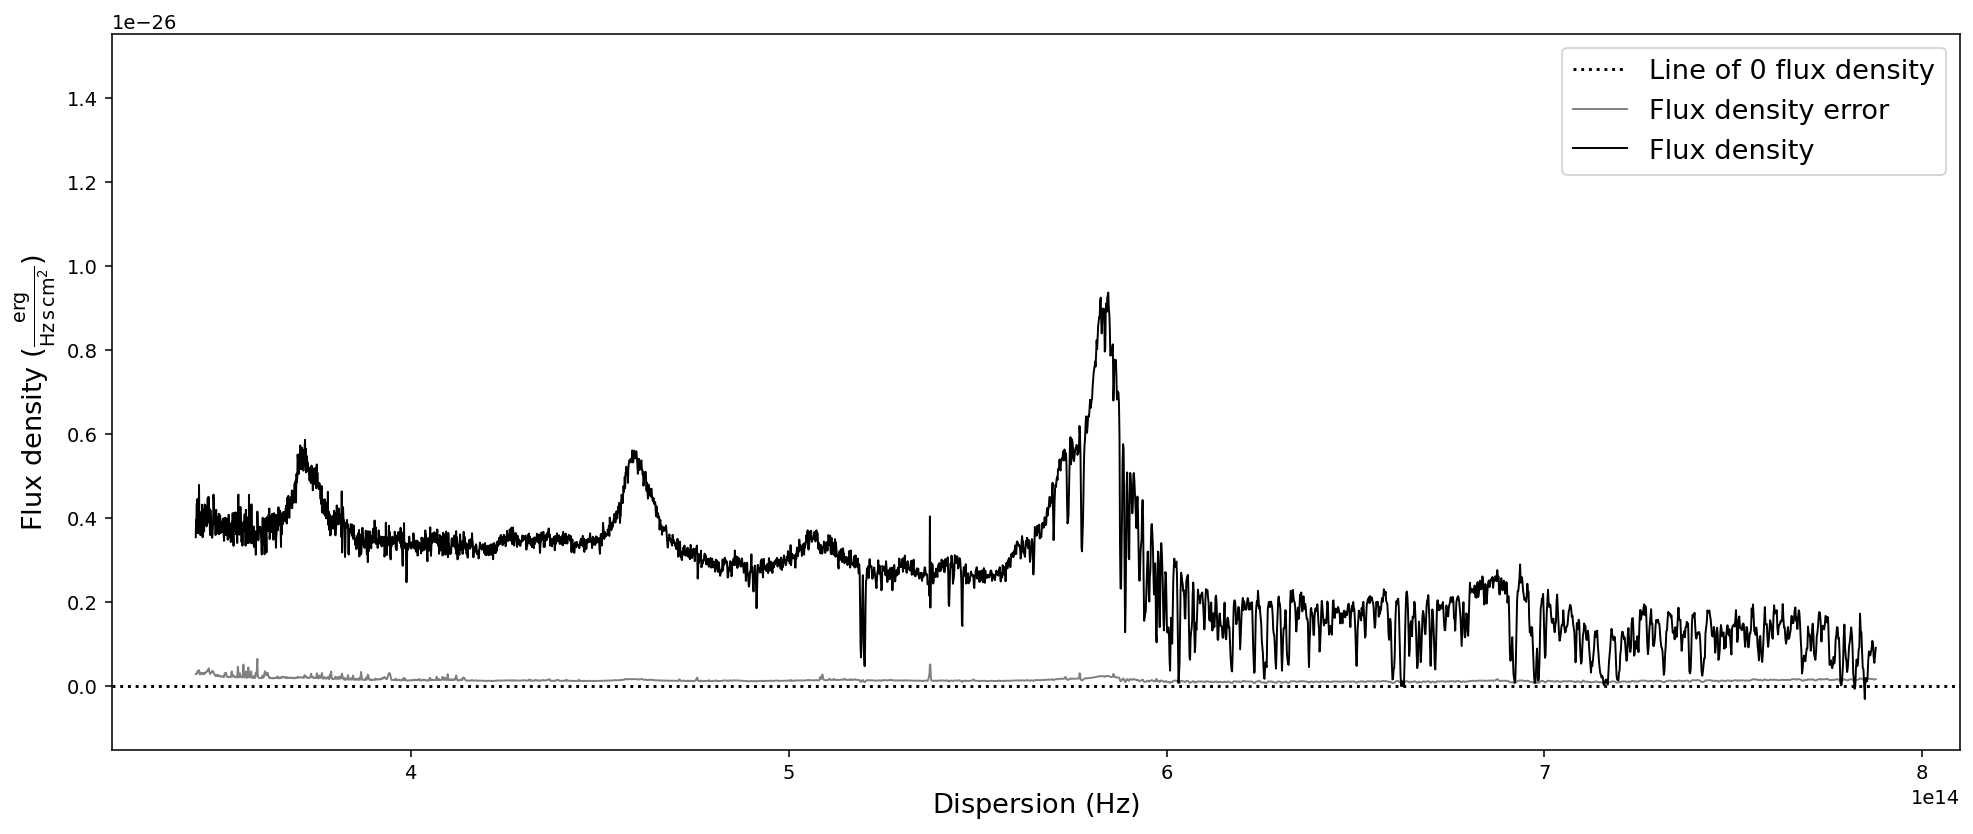

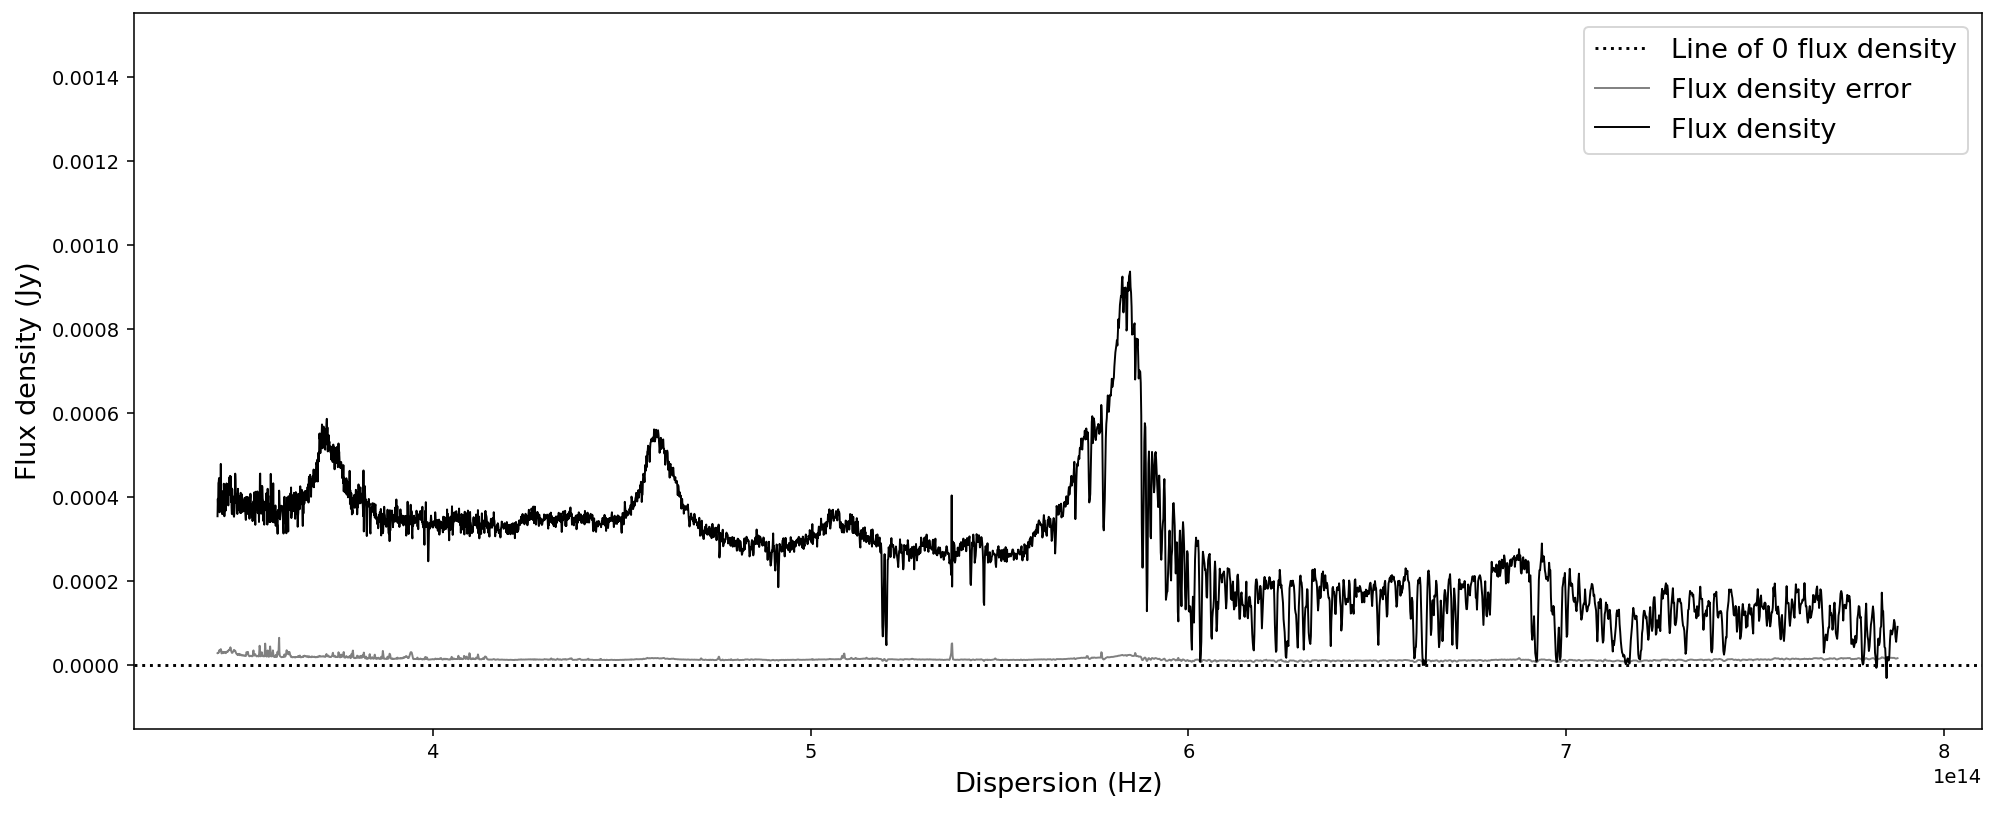

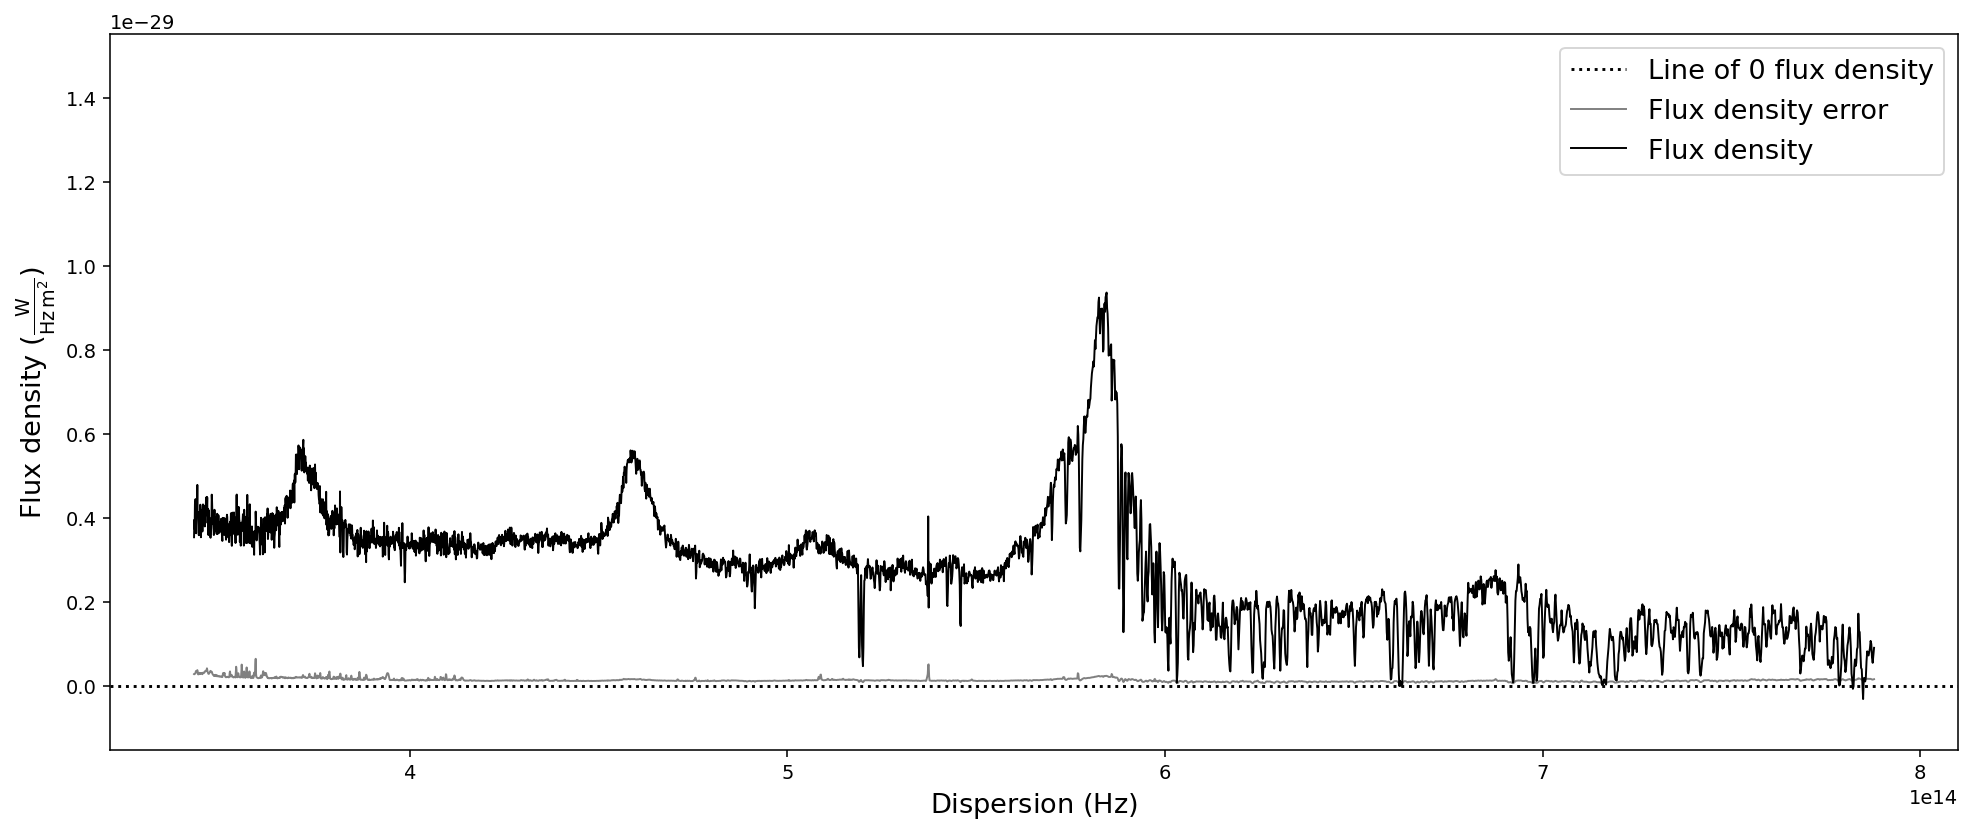

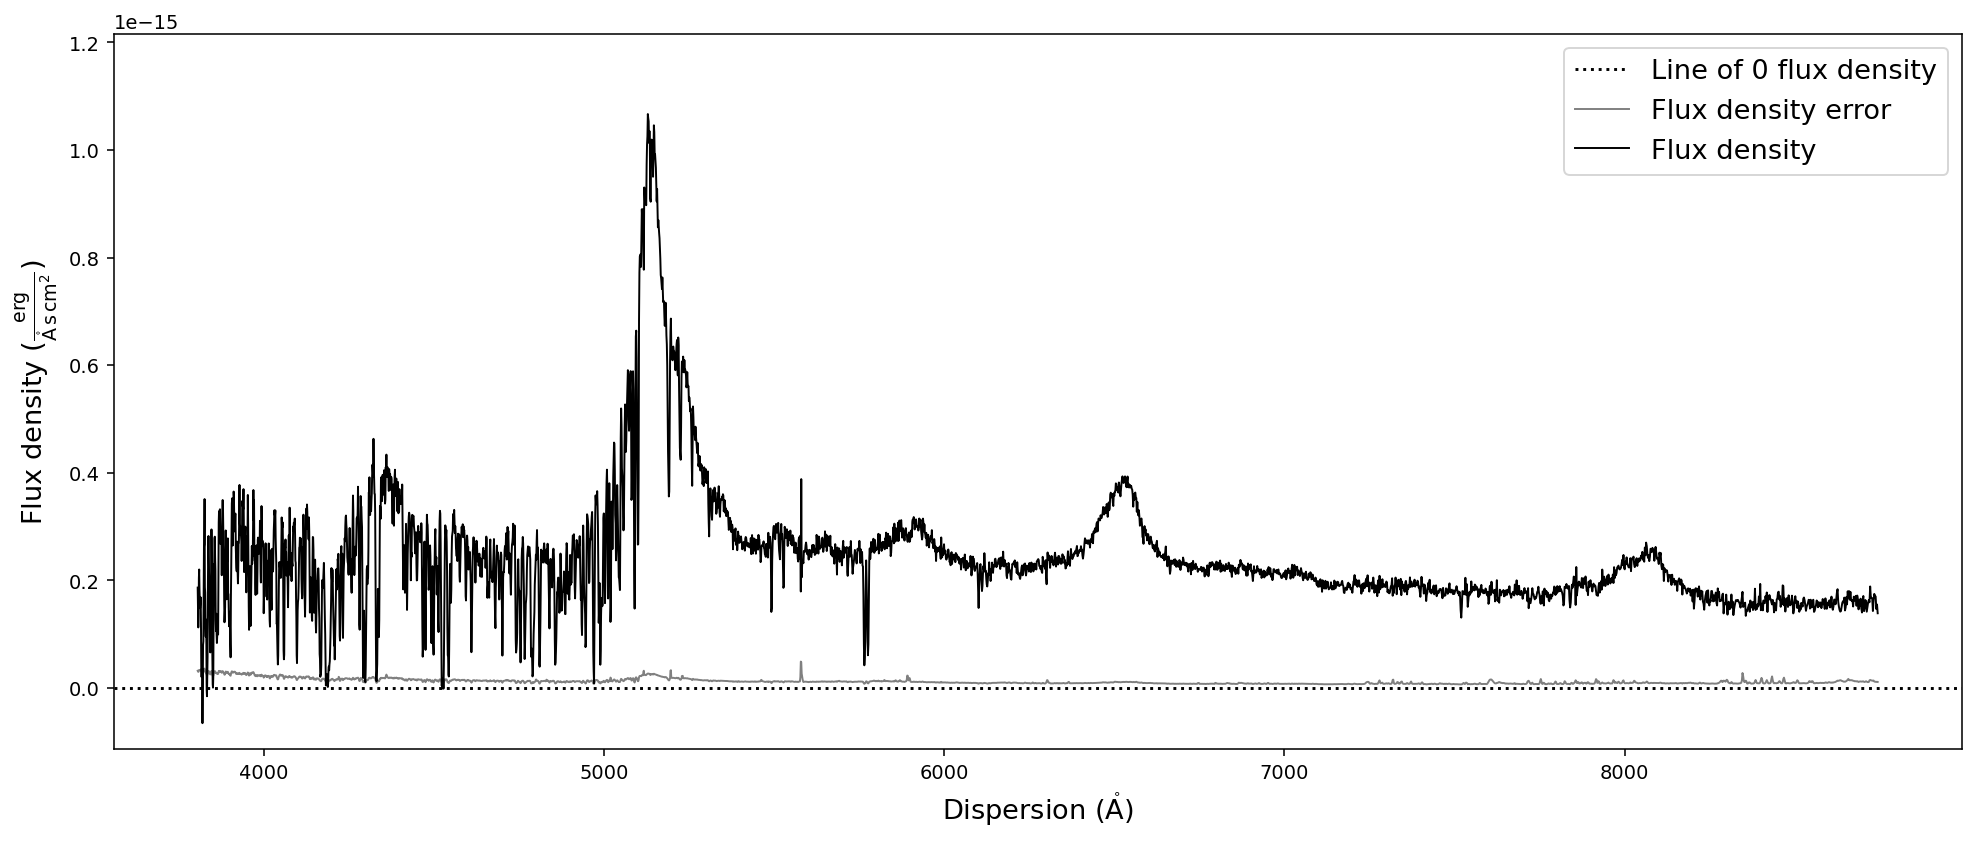

In [12]:
# Convert SpecOneD spectrum to flux density per unit frequency (Hz) in cgs units.
sdss_spec.to_fluxden_per_unit_frequency_cgs()
# Display the spectrum
sdss_spec.plot()

# Convert SpecOneD spectrum to flux density per unit frequency (Hz) in Jy.
sdss_spec.to_fluxden_per_unit_frequency_jy()
# Display the spectrum
sdss_spec.plot()

# Convert SpecOneD spectrum to flux density per unit frequency (Hz) in SI units.
sdss_spec.to_fluxden_per_unit_frequency_si()
# Display the spectrum
sdss_spec.plot()

# Convert SpecOneD spectrum to flux density per unit wavelength (Angstroem) in cgs units.
sdss_spec.to_fluxden_per_unit_wavelength_cgs()
# Display the spectrum
sdss_spec.plot()

After all these conversion the last one brought us back to flux density per unit wavelength in the same units that we originally read the spectrum in - with one major difference: the 1e-17 factor in front of the flux density has been multiplied to the numpy.ndarray of the flux density and been removed from the flux density unit.  However, in these particular units the flux density has very low numerical values, which could pose a problem to fitting algorithms. Therefore, we want to normalize the flux density numerical values and hide large factors in the unit. 

## "Normalizing" the flux density numpy.ndarray

Within SpecOneD we provide three functions that allow "normalize" the flux density numpy.ndarray. The first function calculates the median flux density error and normalizes the flux density unit accordingly. 

**Note that these function return a new SpecOneD object by default. In fact, the majority of the SpecOneD functions that manipulate or modify the spectrum return a modified copy by defaul. This approach is designed to leave the original spectrum *untouched*. However, you can overwrite the original spectrum by using the *inplace* keyword argument of those functions and set it to *True*.**

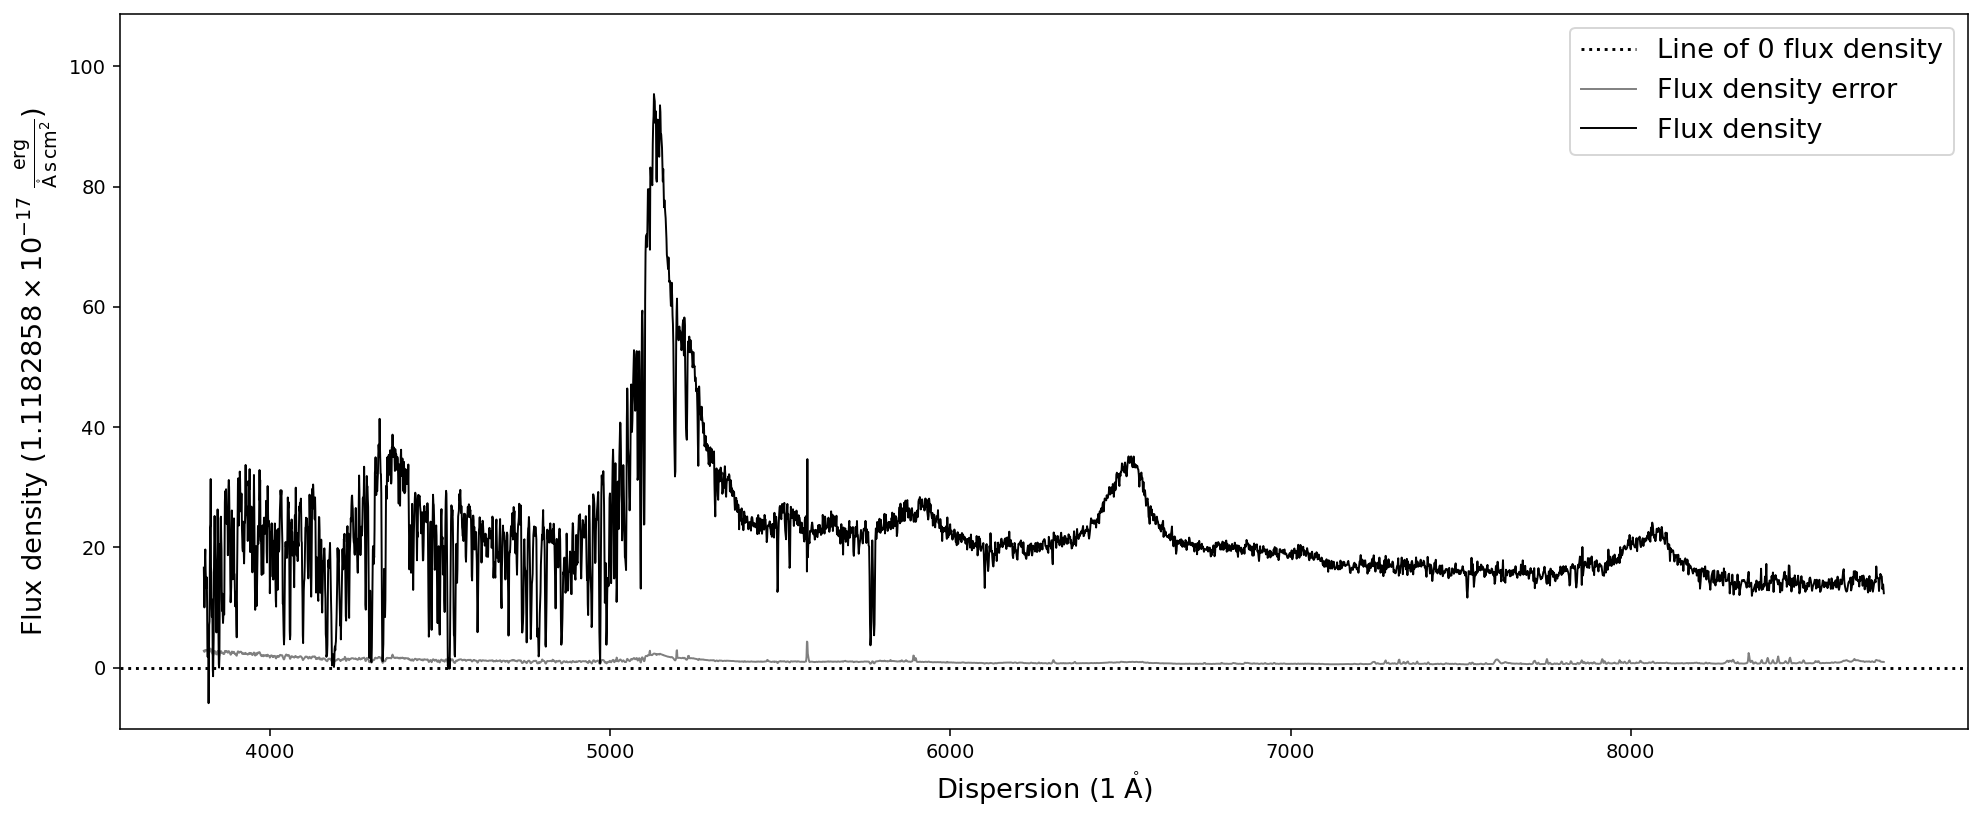

In [13]:
# Normalize flux density unit by flux density error
nspec = sdss_spec.normalize_fluxden_by_error()
nspec.plot()

As you can see, the flux density axis now shows that its unit is ~1.12 * 1e-17 erg/s/cm^2/A. However, in many cases we want to set a specific pre-factor to the flux density unit or modify it by a specific factor. For this purpose two additional functions exist:

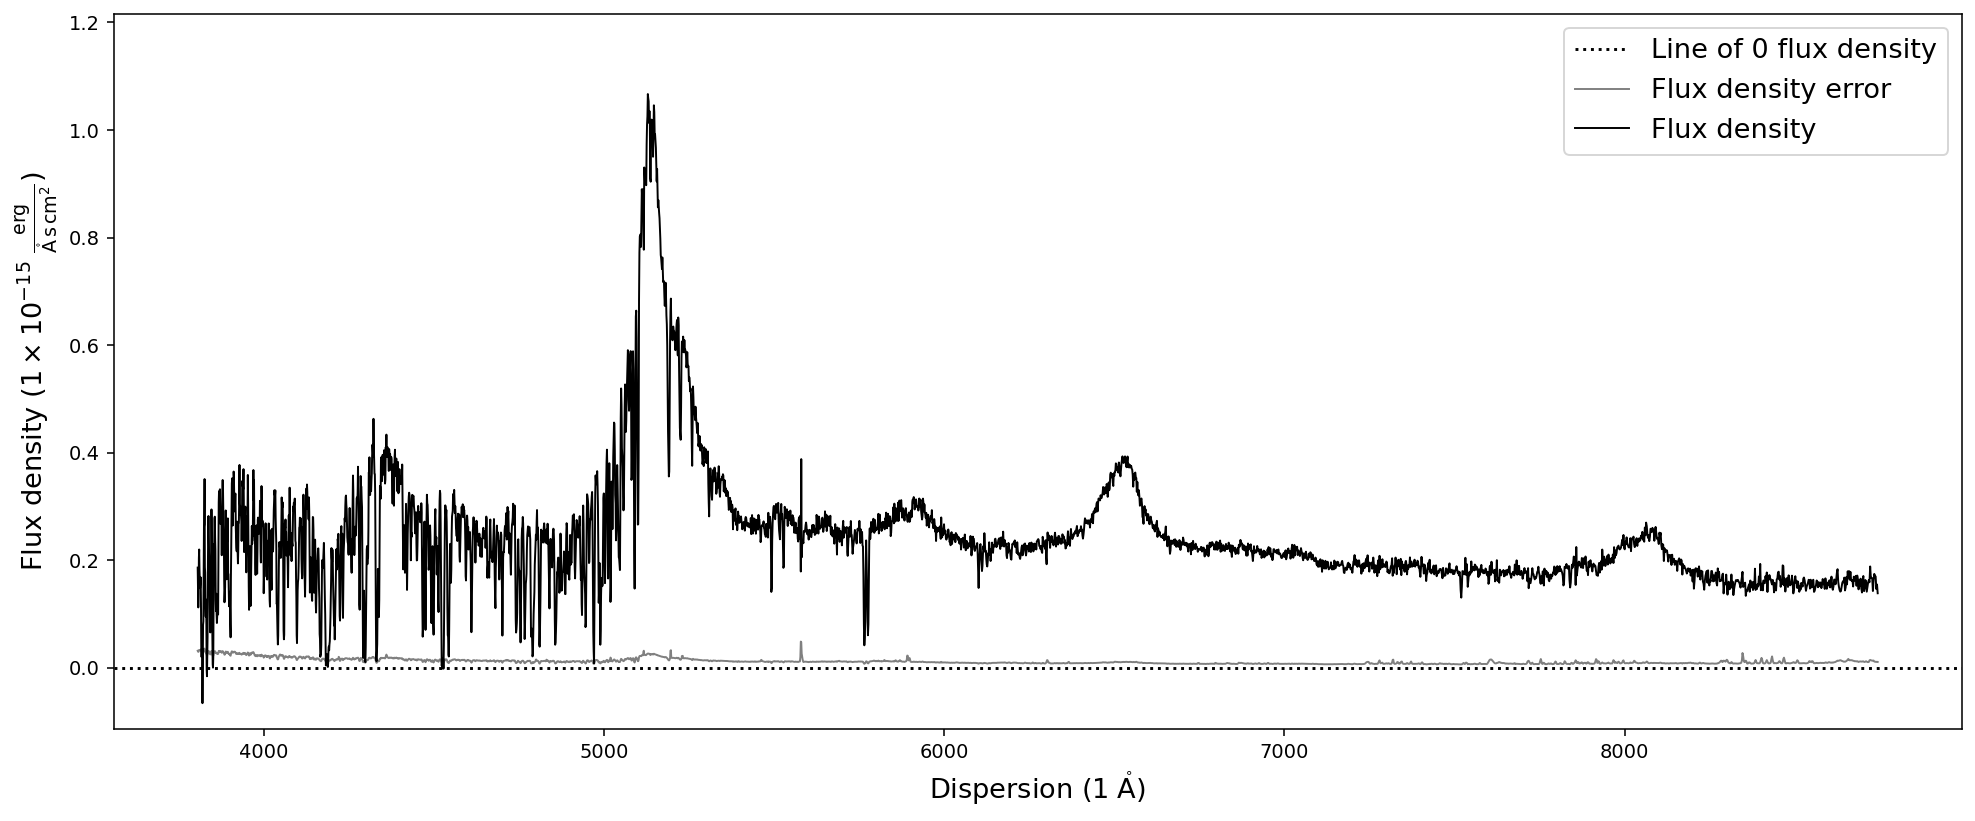

1e-30 erg / (Angstrom cm2 s)


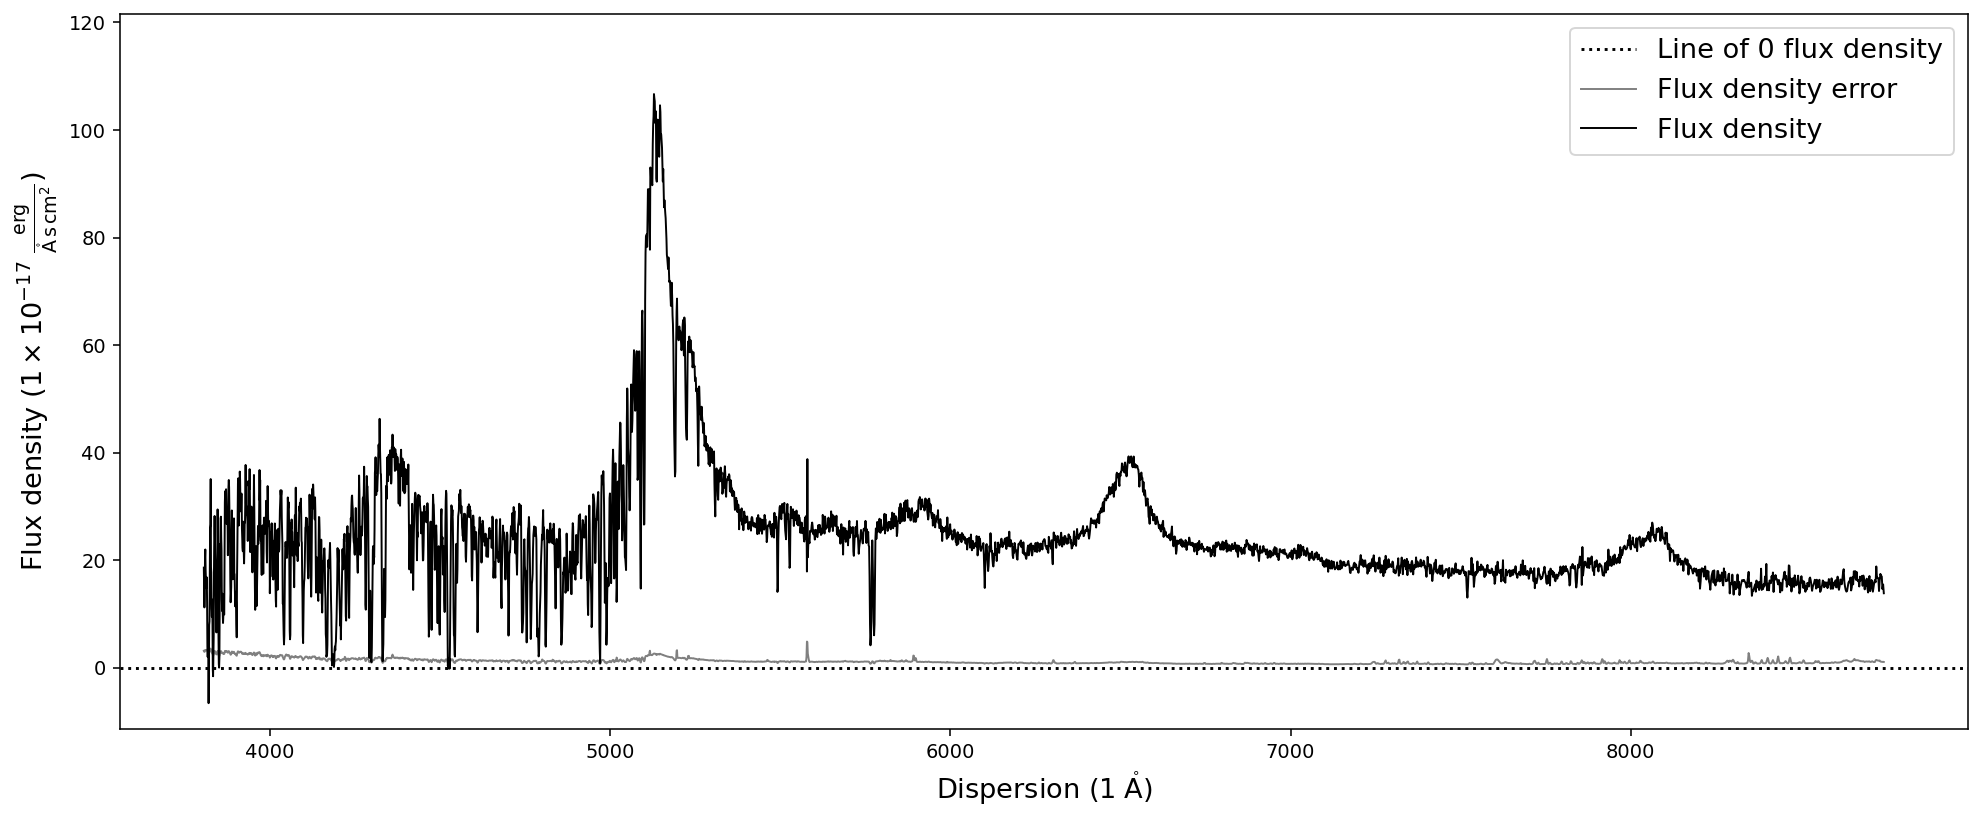

In [16]:
# Normalize the spectrum BY a specific unit factor of 1e-15.
nspec = sdss_spec.normalize_fluxden_by_factor(1e-15)
nspec.plot()

# Applying the same factor again, might lead to ridiculous pre-factors
print(nspec.normalize_fluxden_by_factor(1e-15).fluxden_unit)

# Normalize the spectrum TO a specific unit pre-factor
nspec = sdss_spec.normalize_fluxden_to_factor(1e-17)
nspec.plot()

## Manipulating spectra
### Trimming spectra 
### Interpolation
### Resampling 
### Matching spectra 

# The PassBand class

In [18]:
pb = sod.PassBand('SDSS-z')

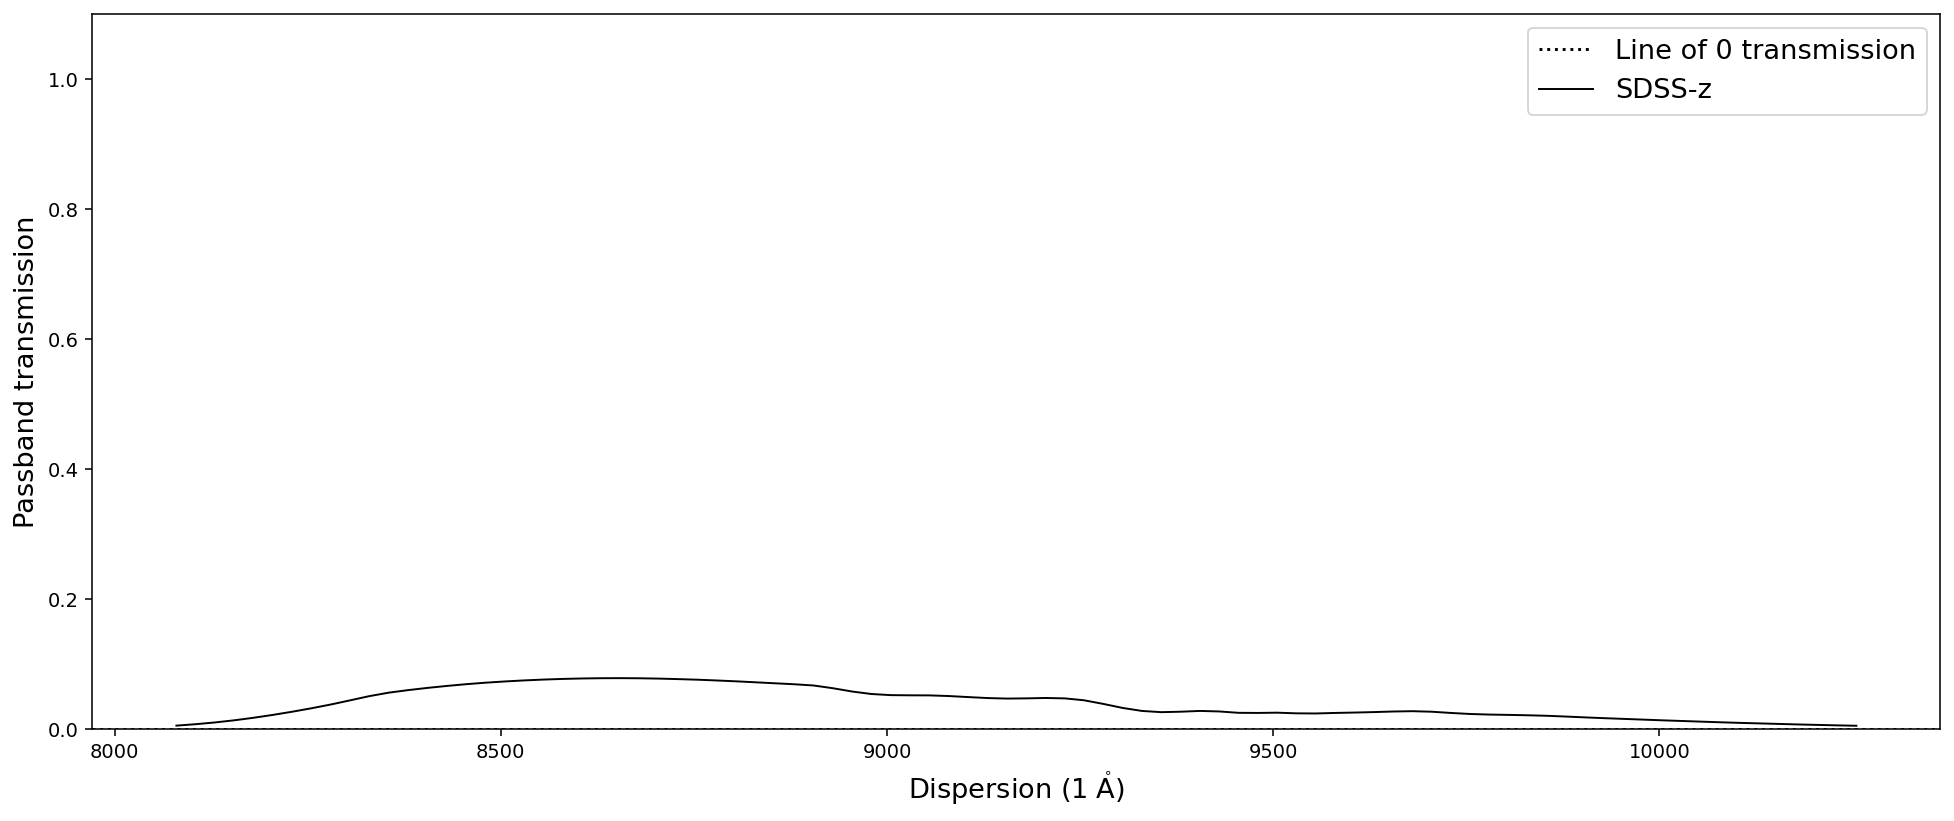

In [19]:
pb.plot()

## Calculating the spectral flux through the passband

In [20]:
spec.read_sdss_fits('../../sculptor/data/example_spectra/J030341.04-002321.8_0.fits')
print(spec.calculate_passband_flux(pb, force=True, match_method='interpolate'))
print(spec.calculate_passband_flux(pb, force=True, match_method='resample'))

[Warning] Force was set to TRUE. The spectrum might not fully fill the passband!
5.538029369158393e-15 erg / (cm2 s)
[Warning] Force was set to TRUE. The spectrum might not fully fill the passband!
[WARNING] Forcing new spectral dispersion axis to be within the limits of the old spectral dispersion.
5.573960274367371e-15 erg / (cm2 s)


In [21]:
print(spec.calculate_passband_ab_magnitude(pb, force=True, match_method='interpolate'))
print(spec.calculate_passband_ab_magnitude(pb, force=True, match_method='resample'))

[Warning] Force was set to TRUE. The spectrum might not fully fill the passband!
17.44295710199735
[Warning] Force was set to TRUE. The spectrum might not fully fill the passband!
[WARNING] Forcing new spectral dispersion axis to be within the limits of the old spectral dispersion.
17.43593061781181


In [22]:
mag = 17.47
# spec.to_fluxden_per_unit_frequency_si()
nspec = spec.renormalize_by_ab_magnitude(mag, pb)
fluxfactor = spec.renormalize_by_ab_magnitude(mag, pb, output_mode='flux_factor')

In [23]:
print(nspec.calculate_passband_ab_magnitude(pb, force=True, match_method='interpolate'))
print(fluxfactor)

[Warning] Force was set to TRUE. The spectrum might not fully fill the passband!
17.47
0.9754002011092436


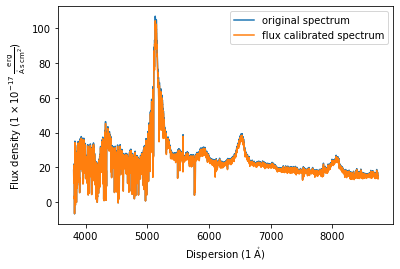

In [24]:
import matplotlib.pyplot as plt
plt.plot(spec.dispersion, spec.fluxden, label='original spectrum')
plt.plot(nspec.dispersion, nspec.fluxden, label='flux calibrated spectrum')
plt.xlabel('Dispersion ({})'.format(spec.dispersion_unit.to_string(format='latex')))
plt.ylabel('Flux density ({})'.format(spec.fluxden_unit.to_string(format='latex')))
plt.legend()

In [25]:
nspec.fluxden_unit.unit, nspec.dispersion_unit

(Unit("erg / (Angstrom cm2 s)"), <Quantity 1. Angstrom>)

In [26]:
spec.renormalize_by_spectrum(nspec, output_mode='flux_factor')

0.9754002011092436

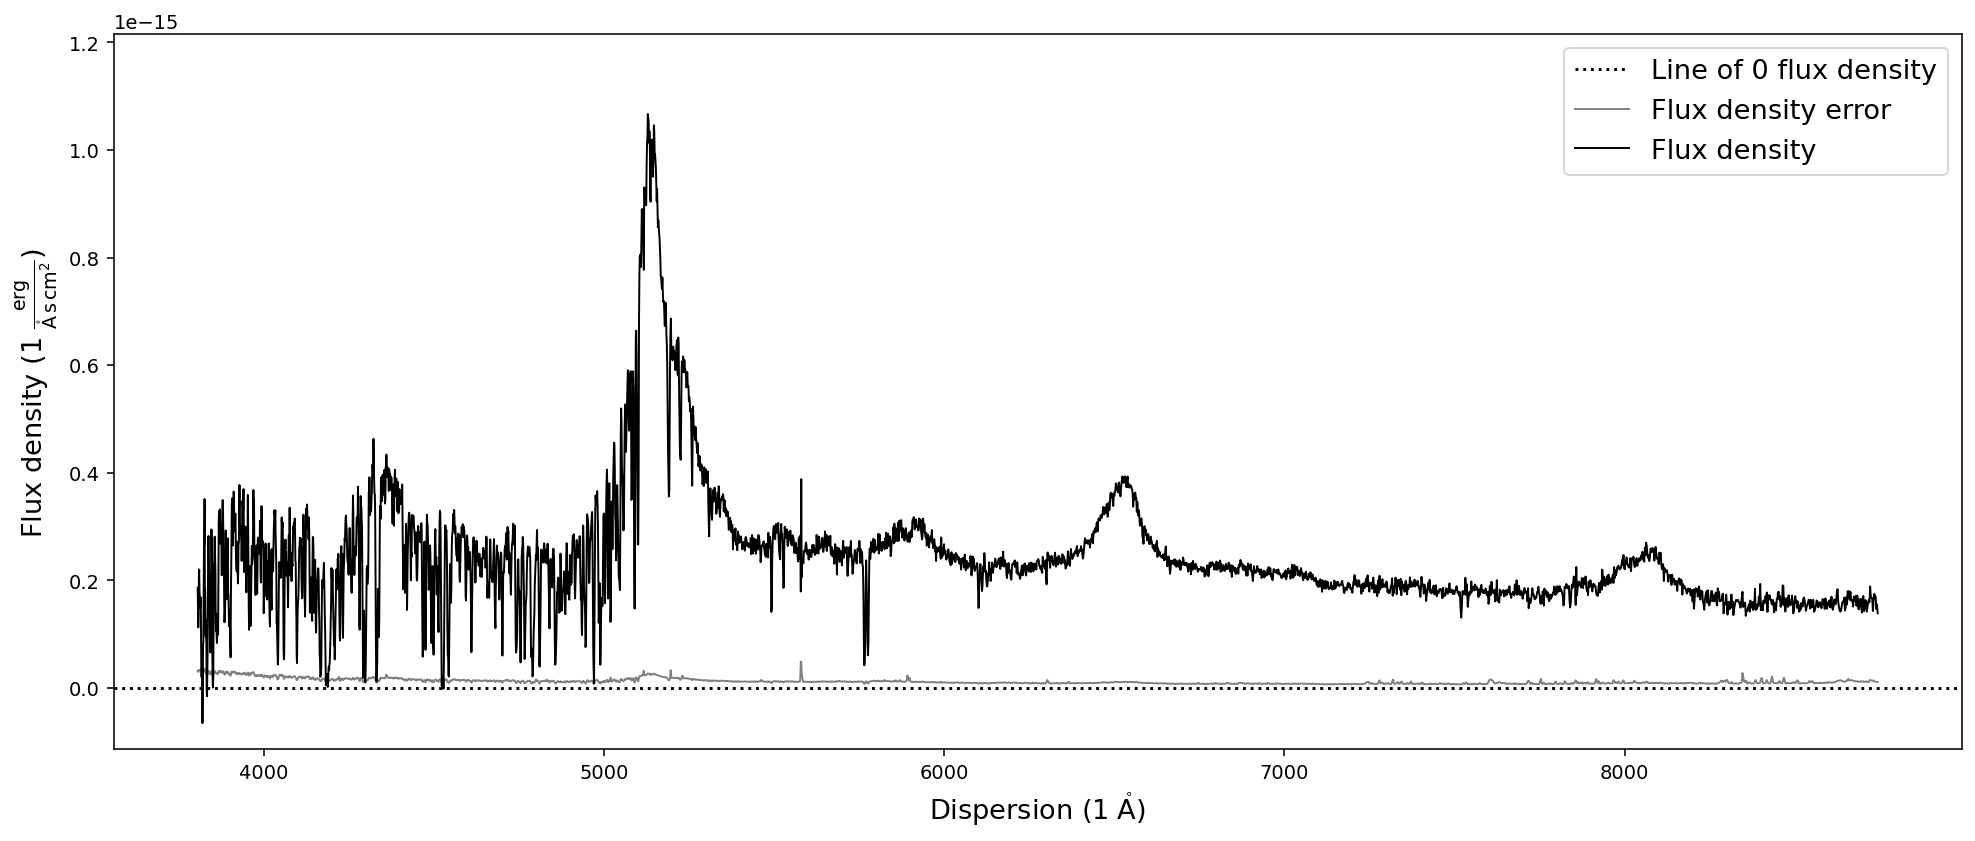

In [27]:
spec.fluxden *= spec.fluxden_unit.value 
spec.fluxden_err *= spec.fluxden_unit.value
spec.get_ivar_from_fluxden_error()
spec.fluxden_unit /= spec.fluxden_unit.value
spec.plot()